In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/s1/bwam9s.mpg
/kaggle/input/dataset/s1/lgbm4p.mpg
/kaggle/input/dataset/s1/bbizzn.mpg
/kaggle/input/dataset/s1/srwo6n.mpg
/kaggle/input/dataset/s1/bgbu3s.mpg
/kaggle/input/dataset/s1/pwax6p.mpg
/kaggle/input/dataset/s1/srwb8n.mpg
/kaggle/input/dataset/s1/sgic1a.mpg
/kaggle/input/dataset/s1/sgbp6p.mpg
/kaggle/input/dataset/s1/sbwo2p.mpg
/kaggle/input/dataset/s1/srit9s.mpg
/kaggle/input/dataset/s1/sgio6n.mpg
/kaggle/input/dataset/s1/srah6p.mpg
/kaggle/input/dataset/s1/prip2p.mpg
/kaggle/input/dataset/s1/sbinzp.mpg
/kaggle/input/dataset/s1/bgaa6n.mpg
/kaggle/input/dataset/s1/pgak2n.mpg
/kaggle/input/dataset/s1/pgwe7s.mpg
/kaggle/input/dataset/s1/bgit7a.mpg
/kaggle/input/dataset/s1/pbwp6n.mpg
/kaggle/input/dataset/s1/bgwb4n.mpg
/kaggle/input/dataset/s1/swbczn.mpg
/kaggle/input/dataset/s1/lrbe8p.mpg
/kaggle/input/dataset/s1/priv6p.mpg
/kaggle/input/dataset/s1/bwbg8n.mpg
/kaggle/input/dataset/s1/sbbbzp.mpg
/kaggle/input/dataset/s1/swwc5s.mpg
/kaggle/input/dataset/s1/pwb

In [3]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2025-06-18 14:29:18.093017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750256958.311214      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750256958.369122      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
    

# 1. Build Data Loading Functions

In [9]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [10]:

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


I0000 00:00:1750256991.864557      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:

char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [14]:

char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [15]:

num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [16]:
def load_alignments(path: str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [17]:
def load_data(path: tf.Tensor):
    path = path.numpy().decode()
    file_name = os.path.basename(path).split('.')[0]
    
    video_path = os.path.join('/kaggle/input/dataset/s1', f'{file_name}.mpg')
    alignment_path = os.path.join('/kaggle/input/dataset/transcription', f'{file_name}.align')
    
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [20]:

test_path = '/kaggle/input/dataset/s1/lbak2p.mpg'

In [21]:

tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/kaggle/input/dataset/s1/lbak2p'

In [22]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.2501713 ],
          [1.2501713 ],
          [1.2501713 ],
          ...,
          [0.49249172],
          [0.5303757 ],
          [0.56825966]],
 
         [[1.2501713 ],
          [1.2501713 ],
          [1.2501713 ],
          ...,
          [0.49249172],
          [0.5303757 ],
          [0.56825966]],
 
         [[1.1365193 ],
          [1.1365193 ],
          [1.1365193 ],
          ...,
          [0.56825966],
          [0.45460773],
          [0.7197956 ]],
 
         ...,
 
         [[0.8713315 ],
          [0.8334475 ],
          [0.8334475 ],
          ...,
          [8.220823  ],
          [8.410243  ],
          [8.4860115 ]],
 
         [[0.8334475 ],
          [0.8334475 ],
          [0.8334475 ],
          ...,
          [8.523895  ],
          [8.145055  ],
          [8.751199  ]],
 
         [[0.8334475 ],
          [0.8334475 ],
          [0.8334475 ],
          ...,
          [9.016387  ],
    

In [23]:

frames, alignments = load_data(tf.convert_to_tensor(test_path))

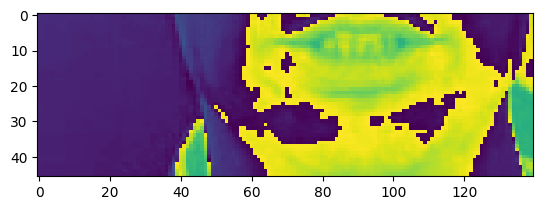

In [24]:
plt.imshow(frames[40])


In [25]:

alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([12,  1, 25, 39,  2, 12, 21,  5, 39,  1, 20, 39, 11, 39, 20, 23, 15,
       39, 16, 12,  5,  1, 19,  5])>

In [26]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['l', 'a', 'y', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'k', ' ', 't', 'w', 'o', ' ', 'p', 'l', 'e', 'a', 's', 'e']


In [27]:

tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at k two please'>

In [28]:

def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result


# 2. Create Data Pipeline

In [29]:
from matplotlib import pyplot as plt

In [30]:
# Adjust to Kaggle dataset path
data = tf.data.Dataset.list_files('/kaggle/input/dataset/s1/*.mpg', shuffle=True)
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)


In [31]:
frames,alignments=data.as_numpy_iterator().next()

In [32]:

len(test)

50

In [33]:

frames, alignments = data.as_numpy_iterator().next()

In [34]:
alignments

array([[19,  5, 20, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39, 10,
        39,  6,  9, 22,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39,  9, 39, 20,
         8, 18,  5,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [35]:

len(frames)

2

In [36]:
test=data.as_numpy_iterator()

In [37]:
val=test.next();
val[0]

array([[[[[ 1.6440533 ],
          [ 1.4911182 ],
          [ 1.2999492 ],
          ...,
          [ 0.30587038],
          [ 0.30587038],
          [ 0.30587038]],

         [[ 1.4528843 ],
          [ 1.6058196 ],
          [ 1.3381829 ],
          ...,
          [ 0.30587038],
          [ 0.30587038],
          [ 0.30587038]],

         [[ 1.4528843 ],
          [ 1.4528843 ],
          [ 1.4528843 ],
          ...,
          [ 0.3441042 ],
          [ 0.30587038],
          [ 0.30587038]],

         ...,

         [[ 1.1087801 ],
          [ 1.0705464 ],
          [ 1.0705464 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0705464 ],
          [ 1.0705464 ],
          [ 1.0705464 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0705464 ],
          [ 1.0705464 ],
          [ 1.0705464 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          

In [38]:

# sample = data.as_numpy_iterator()

In [39]:

video = val[0][0]           # shape: (75, H, W, 1), dtype: float32

# Convert to uint8 [0, 255] for saving as GIF
video = (video * 255).astype(np.uint8)  # now shape is still (75, H, W, 1)

# Squeeze last channel for grayscale (remove trailing 1)
video = np.squeeze(video, axis=-1)      # shape: (75, H, W)

# Save as GIF
imageio.mimsave('./animation.gif', video, fps=10)

In [40]:

# imageio.mimsave('./animation.gif', val[0][1], fps=10)

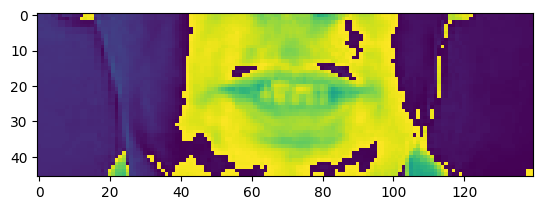

In [41]:

# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [42]:

tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red with t five soon'>

# 3. Design the Deep Neural Network

In [43]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [44]:

data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dummy vocabulary size function
class DummyCharToNum:
    def vocabulary_size(self):
        return 28  # A-Z + space + blank

# char_to_num = DummyCharToNum()

# Input shape: (frames, height, width, channels)
input_layer = tf.keras.Input(shape=(75, 46, 140, 1))

# Conv3D Block 1
x = layers.Conv3D(128, kernel_size=3, padding='same', activation='relu')(input_layer)
x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)

# Conv3D Block 2
x = layers.Conv3D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)

# Conv3D Block 3
x = layers.Conv3D(75, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)

# New shape: (batch, time, height, width, channels)
# Let's reshape to (batch, time, features) for LSTM input
# First, merge H, W, C → Flatten that
shape = x.shape  # (None, 75, 5, 17, 75) based on pooling
time_steps = shape[1]
features = shape[2] * shape[3] * shape[4]  # Flattened features per timestep
x = layers.Reshape((time_steps, features))(x)

# Bi-LSTM layers
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_initializer='orthogonal'))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_initializer='orthogonal'))(x)
x = layers.Dropout(0.5)(x)

# Output layer
output_layer = layers.Dense(char_to_num.vocabulary_size() + 1, activation='softmax')(x)

# Build model
model = models.Model(inputs=input_layer, outputs=output_layer)



In [46]:

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 75, 46, 140, 1)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:

yhat = model.predict(val[0])

I0000 00:00:1750257165.196285     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [48]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'tttzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'>

In [49]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'tttzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'>

In [50]:

model.input_shape

(None, 75, 46, 140, 1)

In [51]:
model.output_shape

(None, 75, 41)


# 4. Setup Training Options and Train

In [52]:

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [53]:

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [54]:

class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None:
        # If it's a tf.data.Dataset, convert to numpy iterator
        if hasattr(dataset, 'as_numpy_iterator'):
            self.dataset = dataset.as_numpy_iterator()
        else:
            # Already a NumpyIterator or list/tuple-based iterator
            self.dataset = dataset
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = next(self.dataset)  # use next() instead of .next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75]*len(yhat), greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [55]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [56]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),  # ✅ proper extension
    monitor='loss',
    save_weights_only=True
)

In [57]:

schedule_callback = LearningRateScheduler(scheduler)

In [58]:

example_callback = ProduceExample(test)

In [59]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


I0000 00:00:1750257201.357081     101 service.cc:148] XLA service 0x1f7f73d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750257201.357933     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750257201.855381     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 52/450 ━━━━━━━━━━━━━━━━━━━━ 4:38 699ms/step - loss: 140.7065

[mpeg1video @ 0x7ddec806d240] ac-tex damaged at 22 17
[mpeg1video @ 0x7ddec806d240] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - loss: 102.6235

ValueError: Unrecognized data type: x=NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7dde4d4cbd10>) (of type <class 'tensorflow.python.data.ops.dataset_ops.NumpyIterator'>)